In [2]:
import connect_tools as ct
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [130]:
password = ""
connexion = ct.Connect_Tools(password=password)
df_ml_champions = connexion.read_db(table_name = "ml_champions")
df_ml_ws_champions = connexion.read_db(table_name = "ml_ws_champions")
connexion.close_conn()

X = df_ml_champions.iloc[:,0:334]
y = df_ml_champions.loc[:,"win_side"]
X_ws = df_ml_ws_champions.iloc[:,0:334]

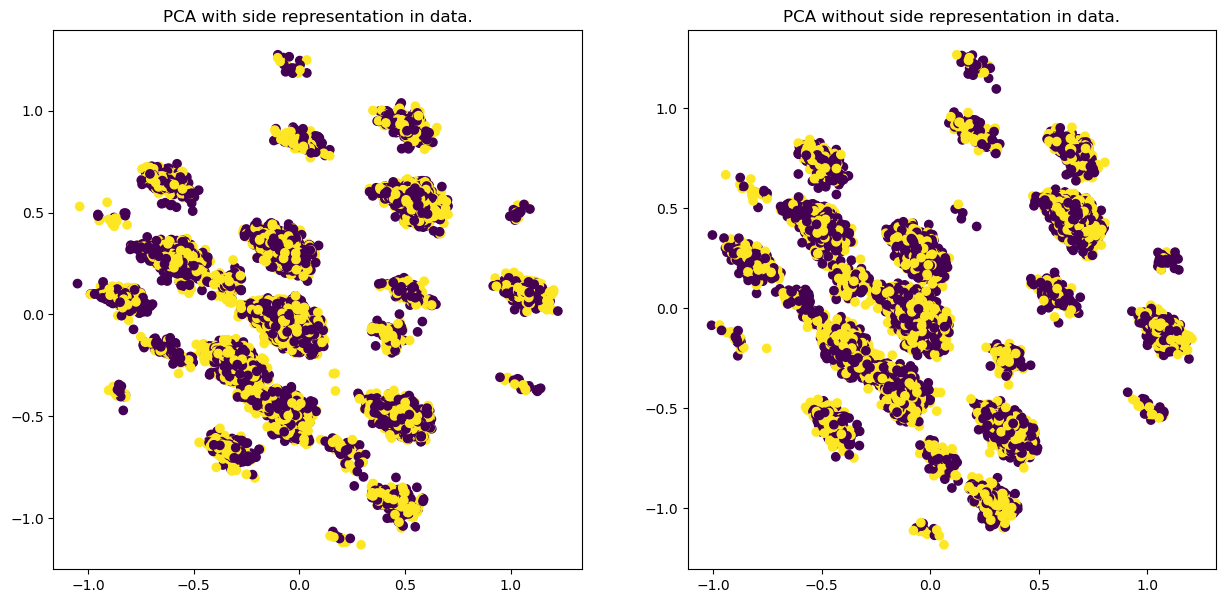

In [43]:
# Visualization data with PCA in 2d space.

model_visualisation_2d = PCA(n_components=2)

X_reduced_2d = model_visualisation_2d.fit_transform(X)
X_ws_reduced_2d = model_visualisation_2d.fit_transform(X_ws)

plt.figure(figsize= (15,7))

plt.subplot(1,2,1)
plt.scatter(X_reduced_2d[:,0], X_reduced_2d[:,1], c=y)
plt.title("PCA with side representation in data.")

plt.subplot(1,2,2)
plt.scatter(X_ws_reduced_2d[:,0], X_ws_reduced_2d[:,1], c=y)
plt.title("PCA without side representation in data.")

plt.show()

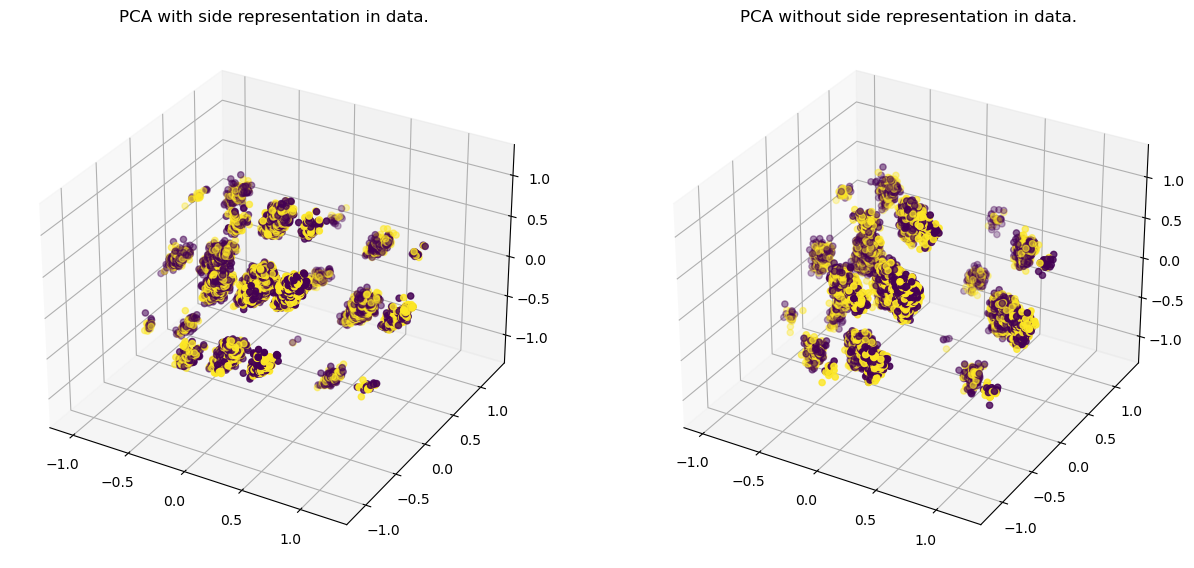

In [44]:
# Visualization data with PCA in 3d space.

model_visualisation_3d = PCA(n_components=3)

X_reduced_3d = model_visualisation_3d.fit_transform(X)
X_ws_reduced_3d = model_visualisation_3d.fit_transform(X_ws)

fig = plt.figure(figsize= (15,7))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(X_reduced_3d[:,0], X_reduced_3d[:,1], X_reduced_3d[:,2], c=y)
ax1.set_title("PCA with side representation in data.")

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(X_ws_reduced_3d[:,0], X_ws_reduced_3d[:,1], X_ws_reduced_3d[:,2], c=y)
ax2.set_title("PCA without side representation in data.")
plt.show()

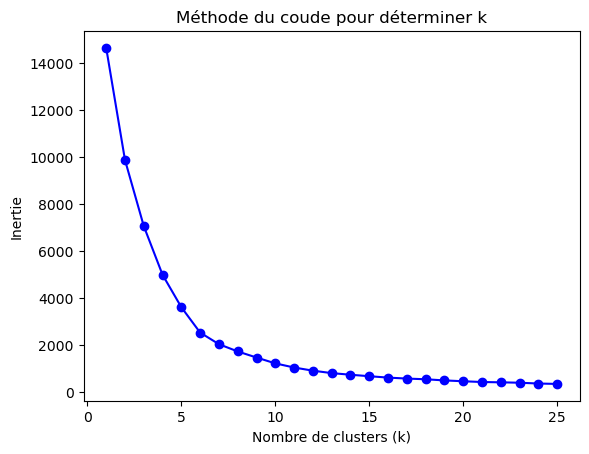

In [16]:
# Just for exemple, not really use it in this case. 

inertia = []
k_range = range(1, 26)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_ws_reduced_3d)
    inertia.append(kmeans.inertia_)

plt.figure()
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer k')
plt.show()

In [6]:
# Separate data in cluster to target one with low rate of victory (and better understanding of PCA fonctioning)

k = 20
analyse_cluster = KMeans(n_clusters=k, random_state=0, n_init=10)
analyse_cluster.fit(X_ws_reduced_3d)

labels = analyse_cluster.labels_

mean_clusters = []

for r in range(0,20):
    mean_clusters.append( y[labels == r].mean())

print(min(mean_clusters))
print(max(mean_clusters))
print(len(X_ws[labels == mean_clusters.index(min(mean_clusters))]))
print(len(X_ws[labels == mean_clusters.index(max(mean_clusters))]))

0.3826086956521739
0.49272727272727274
230
550


In [117]:
# Found champion representing the most low cluster.

password = ""
connexion = ct.Connect_Tools(password=password)
df_matches = connexion.read_db(table_name = "matches")
df_champ = connexion.read_db(table_name="champions_list")
champions = df_champ["name_champ"].to_list()
connexion.close_conn()

df_matches.replace({None: np.nan})
df_matches = df_matches.dropna()

weak_cluster = df_matches[labels == mean_clusters.index(min(mean_clusters))]
count_champ = weak_cluster.iloc[:, 1:11].apply(weak_cluster.iloc[:, 1:11].value_counts).fillna(0)

df_count = pd.DataFrame(data={'Sum' : count_champ.sum(axis=1)})
max_c = df_count["Sum"].max()
print(df_count[df_count["Sum"] == max_c])

           Sum
Senna    230.0
Smolder  230.0


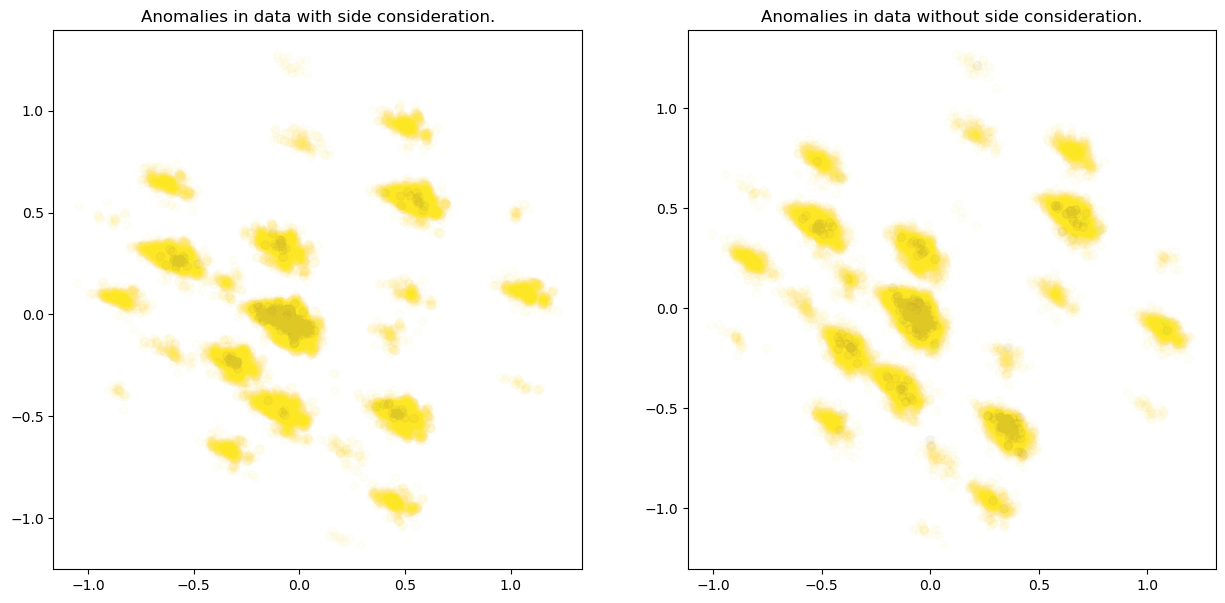

In [118]:
# Use IsolationForest to found outliers in data.

model_IsoForest = IsolationForest(contamination=0.01, random_state=0)
model_IsoForest_ws = IsolationForest(contamination=0.01, random_state=0)
model_IsoForest.fit(X)
model_IsoForest_ws.fit(X_ws)

pred_if = model_IsoForest.predict(X)
pred_if_ws = model_IsoForest_ws.predict(X_ws)

plt.figure(figsize= (15,7))

plt.subplot(1,2,1)
plt.scatter(X_reduced_2d[:,0], X_reduced_2d[:,1], c=pred_if, alpha= 0.03)
plt.title("Anomalies in data with side consideration.")

plt.subplot(1,2,2)
plt.scatter(X_ws_reduced_2d[:,0], X_ws_reduced_2d[:,1], c=pred_if_ws, alpha= 0.03)
plt.title("Anomalies in data without side consideration.")

plt.show()

In [115]:
# Found outliers matches.

outliers = model_IsoForest_ws.predict(X_ws) == -1
df_outliers = df_matches[outliers]
print(df_outliers)

       id_match   red_top       red_jun   red_mid red_bot   red_sup blu_top  \
204         205   Trundle       Kha'Zix     Neeko    Jinx     Milio    Olaf   
282         283   Warwick       Nidalee    Irelia    Ashe     Leona   Nasus   
455         456  Volibear       Kindred     Neeko    Jinx    Thresh  Aatrox   
491         492    Wukong        Graves     Galio  Samira     Leona   Fiora   
503         504     Fiora  Fiddlesticks  Tristana    Jinx    Thresh  Gragas   
...         ...       ...           ...       ...     ...       ...     ...   
36523     36524     Garen       Karthus      Ahri  Kai'Sa  Nautilus  Illaoi   
36783     36784      Sion         Shaco    Viktor    Jhin      Ashe   Yasuo   
36784     36785     Garen       Evelynn     Akali  Lucian    Zilean   Karma   
36788     36789  Malphite      Volibear    Gragas    Jinx      Ashe   Jayce   
36919     36920     Nasus       Evelynn  Katarina  Twitch     Leona    Gnar   

              blu_jun   blu_mid       blu_bot    bl

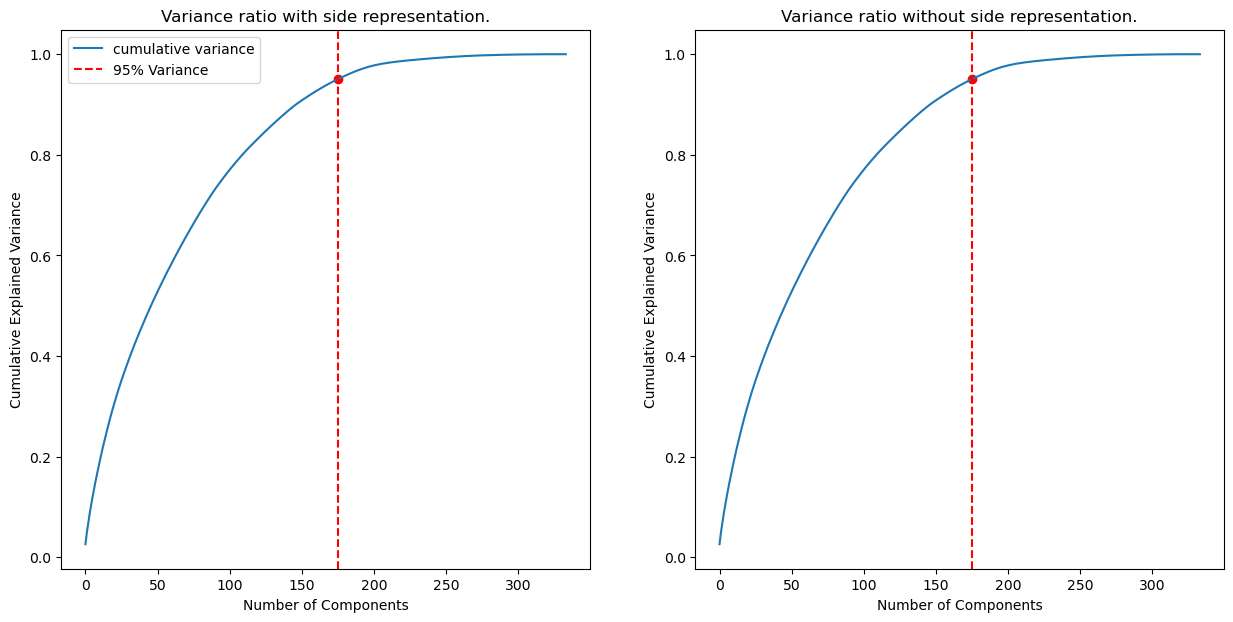

In [129]:
# Found how much can reduce components

f_reduce = PCA(n_components= 334)
f_reduce_ws = PCA(n_components=334)

X_reduced = f_reduce.fit(X)
X_reduced_ws = f_reduce_ws.fit(X)

vr_Xr = np.cumsum(X_reduced.explained_variance_ratio_)
vr_Xr_ws = np.cumsum(X_reduced_ws.explained_variance_ratio_)
index_95_vr = np.argmax(vr_Xr >= 0.95)
index_95_vr_ws = np.argmax(vr_Xr_ws >= 0.95)

plt.figure(figsize= (15,7))
plt.subplot(1,2,1)
plt.plot(vr_Xr, label = 'cumulative variance')
plt.axvline(x=index_95_vr, color='r', linestyle='--', label='95% Variance')
plt.scatter(index_95_vr, vr_Xr[index_95_vr], color='r', marker='o')
plt.title("Variance ratio with side representation.")
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.subplot(1,2,2)
plt.plot(vr_Xr_ws, label = 'cumulative variance')
plt.axvline(x=index_95_vr_ws, color='r', linestyle='--', label='95% Variance')
plt.scatter(index_95_vr_ws, vr_Xr[index_95_vr_ws], color='r', marker='o')
plt.title("Variance ratio without side representation.")
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [133]:
# Reducing data to 95% before split.
PCA_reduce = PCA(n_components= 0.95)
X_r = PCA_reduce.fit_transform(X)
X_r_ws = PCA_reduce.fit_transform(X_ws)
print(X_r.shape)
print(X_r_ws.shape)

(35931, 176)
(35931, 271)


In [135]:
# Split datas.

columns_select = X.columns.to_list()
X_train, X_test, y_train, y_test = train_test_split(X_r, y, test_size=0.2, random_state = 0, stratify = y)
X_ws_train, X_ws_test, y_ws_train, y_ws_test = train_test_split(X_r_ws, y, test_size=0.2, random_state = 0, stratify = y)
print(X_train.shape)
print(X_test.shape)
print(X_ws_train.shape)
print(X_ws_test.shape)

(28744, 176)
(7187, 176)
(28744, 271)
(7187, 271)


In [136]:
# Parametres for gridsearchCV

model_SVC = SVC()
model_SGDC = SGDClassifier()
model_DTC = DecisionTreeClassifier()
model_RFC = RandomForestClassifier()
estimators = [model_SVC]

param_SVC = {'C' : [0.5, 1.0, 1.5, 2.0],
             'kernel' : ['linear', 'poly', 'rbf']}

param_SGDC = {'loss' : ['hinge', 'log_loss', 'log'],
                       'penalty' : ['l2', 'l1']}

param_DTC = {'criterion' : ['gini', 'entropy', 'log_loss'],
              'splitter' : ['best', 'random'],
              'max_depth' : np.arange(5, 35 , 5),
              'max_features' : ['auto', 'sqrt', 'log2']}

param_RFC = {'n_estimators' : [np.arange(50, 250, 50)],
                                'criterion' : ['gini', 'entropy', 'log_loss'],
                                'max_depth' : [np.arange(4, 12, 2)],
                                'max_features': ['auto', 'sqrt', 'log2']}
params = [param_SVC]

all_estimators = [(estimator, param) for estimator, param in zip(estimators, params)]

In [137]:
list_grid = []
for i in all_estimators:
    grid = GridSearchCV(estimator= i[0], param_grid=i[1], cv=5)
    grid.fit(X_train, y_train)
    results = [grid.best_estimator_, grid.best_params_, grid.best_score_, grid.best_estimator_]
    list_grid.append(results)

print(list_grid)

In [18]:
list_grid

[]